In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('data/train.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(6), object(2)
memory usage: 7.9+ MB


In [4]:
train_data.isna().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

In [5]:
print(train_data.id[1:5] ,"\n", train_data.id[1:5])

1    41492
2    31300
3    19415
4    99379
Name: id, dtype: int64 
 1    41492
2    31300
3    19415
4    99379
Name: id, dtype: int64


In [6]:
train_data.id[(train_data["Count_3-6_months_late"].isna()) 
              & (train_data["Count_6-12_months_late"].isna())
              & (train_data["Count_more_than_12_months_late"].isna())].count()

97



So we can see the 97 NA values are all in the same 97 Rows


So it would be wise to just delete this rows so they don't effect the model




Before we delete we create a model to keep a record of the deleted N/A rows

In [7]:
train_data["pay_late_na"] = train_data["Count_3-6_months_late"].isna().astype(int)

In [8]:
train_data=train_data[train_data["pay_late_na"]==0]

In [9]:
train_data.application_underwriting_score.describe()

count    76855.000000
mean        99.067053
std          0.739789
min         91.900000
25%         98.810000
50%         99.210000
75%         99.540000
max         99.890000
Name: application_underwriting_score, dtype: float64

In [10]:
print(train_data.application_underwriting_score.mean())
col=["sourcing_channel", "residence_area_type"]
for c in col:
    print(train_data.groupby(c).application_underwriting_score.mean())

99.06705315203956
sourcing_channel
A    99.102131
B    99.055758
C    98.979302
D    99.038134
E    99.067980
Name: application_underwriting_score, dtype: float64
residence_area_type
Rural    99.062508
Urban    99.070048
Name: application_underwriting_score, dtype: float64


 
So we can see two things:
* very less _scattering_ in **application_underwriting_score** and very low std-dev
* Almost same mean across all the **sourcing_channel** and **residence_area_type**





SO we can impute the missing data __application_underwriting_score__ with its mean

In [11]:
train_data['application_underwriting_score'].fillna(train_data.application_underwriting_score.mean(), inplace=True)


In [12]:
train_data.isna().sum().sum()
#check 

0

In [13]:
#Adding a few more features

train_data["total_count"]=(train_data['Count_3-6_months_late']+train_data['Count_6-12_months_late']+train_data['Count_more_than_12_months_late']+train_data['no_of_premiums_paid'])

train_data["total_late_payment"]=(train_data['Count_3-6_months_late']+train_data['Count_6-12_months_late']+train_data['Count_more_than_12_months_late'])

train_data["ratio_late_payment"]=(train_data['Count_3-6_months_late']+train_data['Count_6-12_months_late']+train_data['Count_more_than_12_months_late'])


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79756 entries, 0 to 79852
Data columns (total 17 columns):
id                                  79756 non-null int64
perc_premium_paid_by_cash_credit    79756 non-null float64
age_in_days                         79756 non-null int64
Income                              79756 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      79756 non-null float64
no_of_premiums_paid                 79756 non-null int64
sourcing_channel                    79756 non-null object
residence_area_type                 79756 non-null object
premium                             79756 non-null int64
renewal                             79756 non-null int64
pay_late_na                         79756 non-null int64
total_count                         79756 non-null float64
total_late_payment    

### Correlation

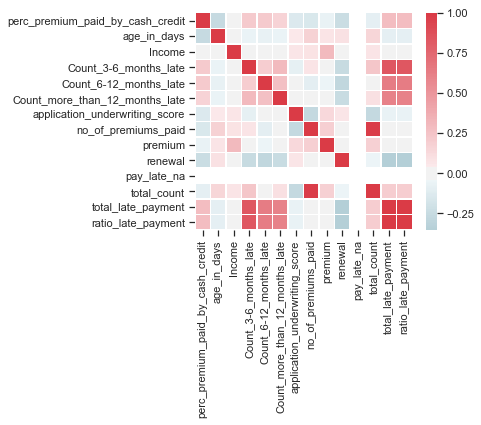

In [15]:
#list of cols for correlation test
d = (list(train_data.columns[1:9])+list(train_data.columns[11:17]))

corr = train_data[d].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5)


### From Correlation Plot

* __Total_count__ and __no_of_premeiums_paid__ is highly correlated so one should be discarded. 

* We can see some correlation between late payments in the three categories (3-6, 6-12 and >12)
    * possibly because similar pay late across all categories
    * the 3-6 could be a subset of 6-12 or >12 (we should check for this possibility)

In [16]:
#drop total count
train_data.drop(labels=["total_count"], axis=1, inplace=True)

In [17]:
#Seperate id and label
Id=train_data.id
label=pd.DataFrame({'target':train_data.renewal})

#drop id and renewal
train_data.drop(labels=["id", "renewal"], axis=1, inplace=True)


In [18]:
#one hot encoding fo non-numerical variables
train_data=pd.get_dummies(train_data)

In [23]:
#processed data to csv
train_data.to_csv("data/train_data.csv", index=False)

#labels to csv
label.to_csv("data/train_target.csv", index=False)

In [20]:
#create train and test dataset
X_train, X_test, y_train, y_test = train_test_split(train_data, label, train_size=0.75,
                                                    test_size=0.25, random_state=1)

In [24]:
#export as csv files

X_train.to_csv("data/X_train.csv", index=False)
X_test.to_csv("data/X_test.csv", index=False)
y_train.to_csv("data/train_labels.csv", index=False)
y_test.to_csv("data/test_labels.csv", index=False)